In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
sys.path.append("../../../") 

from utils.paths import make_dir_line

modality = 'c'
project = 'Database Design'
data = make_dir_line(modality, project)

raw = data('raw')

In [5]:
import sqlite3

conn = sqlite3.connect(":memory:")  ## aca se indica el nombre de la db.
cur = conn.cursor()

# 7.1.0 Processing, Storing, and Organizing Data

## 7.1.2 OLAP vs. OLTP

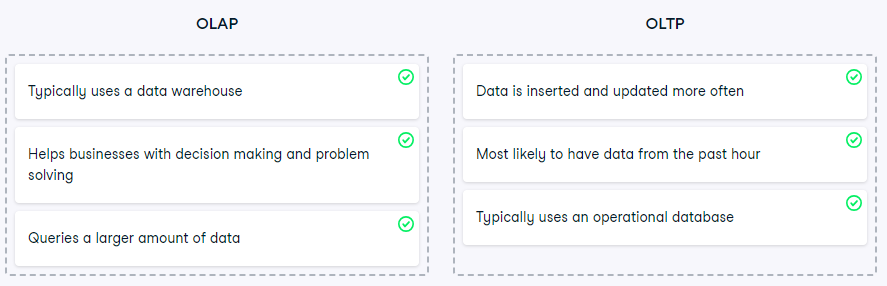

## 7.1.3 Which is better?

Question:  What data processing approach is this larger repository most likely using?

In [6]:
potholes = pd.read_csv(raw / 'potholeschicago.csv', sep = ',', decimal = '.', header = 0, encoding = 'utf-8')
potholes.head()

,CREATION DATE,STATUS,COMPLETION DATE,SERVICE REQUEST NUMBER,TYPE OF SERVICE REQUEST,MOST RECENT ACTION,STREET ADDRESS,ZIP
0,2018-12-17T00:00:00.000,Open,NaN,18-03380123,Pothole in Street,NaN,10300 S WALLACE ST,60628.0
1,2018-12-18T00:00:00.000,Open,NaN,18-03388180,Pothole in Street,NaN,4100 S WESTERN BLVD,60609.0
2,2018-12-18T00:00:00.000,Open,NaN,18-03388493,Pothole in Street,NaN,5230 S NEW ENGLAND AVE,60638.0
3,2018-12-17T00:00:00.000,Open,NaN,18-03386050,Pothole in Street,NaN,1053 E 92ND ST,60619.0
4,2018-12-17T00:00:00.000,Open,NaN,18-03382135,Pothole in Street,NaN,4756 W 85TH ST,60652.0


In [7]:
potholes['SERVICE REQUEST NUMBER'].nunique() == potholes.shape[0]

True

R:/ OLTP because this table's structure appears to require frequest update. This table probably uses an OLTP approach because it is updated and holds data from the past week.

## 7.1.5 Name that data type!

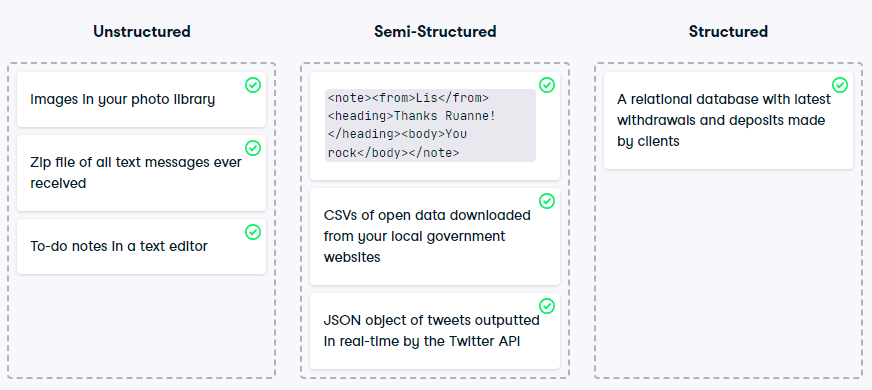

## 7.1.6 Ordering ETL Tasks

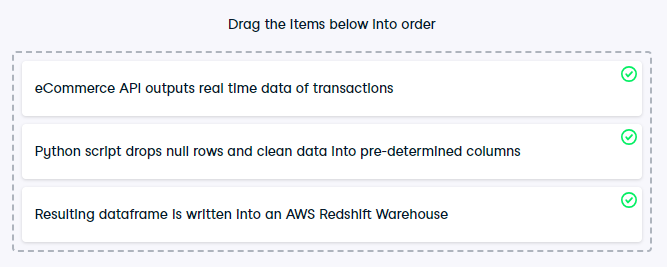

## 7.1.7 Recommend a storage solution

Question: When should you choose a data warehouse over a data lake?

R:/ To create accessible and isolated data repositories for other analysts. Analysts will appreciate working in a data warehouse more because of its organization of structured data that make analysis easier.

## 7.1.9 Classifying data models

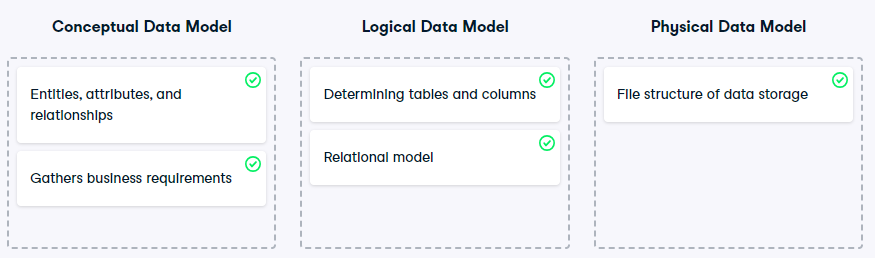

## 7.1.10 Deciding fact and dimension tables

In [8]:
runs = pd.read_csv(raw / 'runs.csv', sep = ',', decimal = '.', header = 0, encoding = 'utf-8')
runs.head()

,duration_mins,week,month,year,park_name,city_name,distance_km,route_name
0,24.5,3,May,2019,Prospect Park,Brooklyn,5,Simple Loop
1,61.0,3,May,2019,Central Park,New York City,8,Resevoir Loop
2,24.5,3,May,2019,Central Park,New York City,5,Lake Loop
3,24.5,4,May,2019,Central Park,New York City,5,Lake Loop
4,48.0,4,May,2019,Prospect Park,Brooklyn,10,Grove Run


Question: Out of these possible answers, what would be the best way to organize the fact table and dimensional tables?

R:/ A fact table holding duration_mins and foreign keys to dimension tables holding route details and week details respectily.

In [9]:
# -- Create a route dimension table, week

conn.executescript(
    """
    
    DROP TABLE IF EXISTS route;

    CREATE TABLE route (
        route_id INTEGER PRIMARY KEY,
        park_name VARCHAR(160) NOT NULL,
        city_name VARCHAR(160) NOT NULL,
        distance_km FLOAT NOT NULL,
        route_name VARCHAR(160) NOT NULL
    );
    
    DROP TABLE IF EXISTS week;
    
    CREATE TABLE week(
        week_id INTEGER PRIMARY KEY,
        week INTEGER NOT NULL,
        month VARCHAR(160) NOT NULL,
        year INTEGER NOT NULL
    );

    """
)
conn.commit()

## 7.1.11 Querying the dimensional model

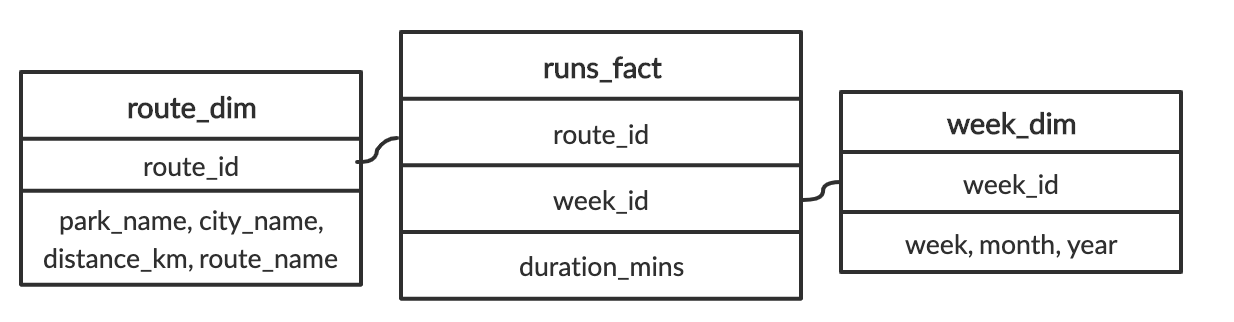

In [10]:
conn.executescript(
    """
    
    DROP TABLE IF EXISTS runs_fact;

    CREATE TABLE runs_fact (
        route_id INTEGER NOT NULL,
        week_id INTEGER NOT NULL,
        duration_mins FLOAT NOT NULL
    );
    
    DROP TABLE IF EXISTS week_dim;
    
    CREATE TABLE week_dim(
        week_id INTEGER PRIMARY KEY,
        week INTEGER NOT NULL,
        month VARCHAR(160) NOT NULL,
        year INTEGER NOT NULL
    );
    
    DROP TABLE IF EXISTS route_dim;
    
    CREATE TABLE route_dim(
        route_id INTEGER PRIMARY KEY,
        park_name VARCHAR(160) NOT NULL,
        city_name VARCHAR(160) NOT NULL,
        distance_km FLOAT NOT NULL,
        route_name VARCHAR(160) NOT NULL
    );

    """
)
conn.commit()

In [11]:
df = pd.read_csv(raw / 'runs_fact.csv', sep = ',', decimal = '.', header = 0, encoding = 'utf-8')
runs_fact = list(zip(df.route_id, df.week_id, df.duration_mins))
cur.executemany("INSERT INTO runs_fact VALUES  (?,?,?)", runs_fact)

df = pd.read_csv(raw / 'week_dim.csv', sep = ',', decimal = '.', header = 0, encoding = 'utf-8')
week_dim = list(zip(df.week_id, df.week, df.month, df.year))
cur.executemany("INSERT INTO week_dim VALUES  (?,?,?,?)", week_dim)

df = pd.read_csv(raw / 'route_dim.csv', sep = ',', decimal = '.', header = 0, encoding = 'utf-8')
route_dim = list(zip(df.route_id, df.park_name, df.city_name, df.distance_km, df.route_name))
cur.executemany("INSERT INTO route_dim VALUES  (?,?,?,?,?)", route_dim)

## 7.1.12 Querying the dimensional model

In [12]:
# -- Select the sum of the duration of all runs
cur.execute("""
            
            SELECT SUM (duration_mins)
            FROM runs_fact;

            """).fetchall()

[(1172.1599999999999,)]

In [13]:
# -- Get the total duration of all runs, Get all the week_id's that are from July, 2019
cur.execute("""
            
            SELECT SUM(duration_mins)
            FROM runs_fact
            INNER JOIN week_dim ON runs_fact.week_id = week_dim.week_id
            WHERE month = 'July' and year = '2019';

            """).fetchall()

[(381.46000000000004,)]

In [14]:
print('Ok_')

Ok_
